# 確認項目
- 様々な学習形式を実装する（ミニバッチ、バッチ、オンライン）
- Validationデータを用いて、精度を確認する
- 3~5層のDNNを実装する
- BatchNormalizationやDropOutを用いて、過学習対策を行う
- 様々な重み初期化を試す
- tensorboardを用いて、デバッグする
- tf debuggerを用いて、デバッグする

In [1]:
#Importします
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from sklearn.model_selection import train_test_split
import time

#時間測定はじめ
start = time.perf_counter()

#データセットを定義します
train_df = pd.read_csv("./input/train.csv")
x = train_df.drop('label', axis=1)
y = pd.get_dummies(train_df['label'])
x = np.array(x)
y = np.array(y)

#検証のために最初にtrainとtest(検証データ）を分けておく
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

#入力データxと正解出力データtを変数tf.placeholder()を使って定義していきます
x = tf.placeholder(tf.float32, [None, 784], name='x')
t = tf.placeholder(tf.float32, [None, 10], name='t')

#重みとバイアス、Hidden層、モデルの出力を定義します
W1 = tf.Variable(tf.random_normal([784, 512], mean=0.0, stddev=0.05), name='W1')
b1 = tf.Variable(tf.zeros([512]), name='b1')
n_norm = tf.layers.batch_normalization(tf.matmul(x, W1) + b1, training=True, name='n_norm')
h = tf.nn.relu(n_norm, name = 'h')

W2 = tf.Variable(tf.random_normal([512,10], mean=0.0, stddev=0.05), name='W2')
b2 = tf.Variable(tf.zeros([10]), name='b2')
y = tf.nn.softmax(tf.matmul(h, W2) + b2, name='y')


#Withであとで呼び出せるようにしながら以下を定義
#Cross_Entropy
with tf.name_scope('cross_entropy'):
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(t * tf.log(y) + (1 - t) * tf.log(1 - y), reduction_indices=[1]))

#accuracy
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(t, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
#train
with tf.name_scope('train') as scope:
    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
    acc_summary_train = tf.summary.scalar("train_acc", accuracy)
    loss_summary_train = tf.summary.scalar("cross_entropy_train", cross_entropy)

#validation
with tf.name_scope("val") as scope:
    acc_summary_val = tf.summary.scalar("val_acc", accuracy)
    loss_summary_val = tf.summary.scalar("cross_entropy_val", cross_entropy)

    
    
# Tensor Boardへ出すヒストグラムサマリーを定義
w1_hist = tf.summary.histogram("weights1", W1)
b1_hist = tf.summary.histogram("biases1", b1)
n_norm_hist = tf.summary.histogram("n_norm", n_norm)
h_hist = tf.summary.histogram("h", h)
w2_hist = tf.summary.histogram("weights2", W2)
b2_hist = tf.summary.histogram("biases2", b2)
y_hist = tf.summary.histogram("y", y)

# セッションを用いる
sess = tf.Session()
sess.run(tf.global_variables_initializer())

#Tensor BoardにMNISTとして吐き出し準備する
writer = tf.summary.FileWriter('Kaggle-MNIST', sess.graph)
merged = tf.summary.merge_all()


# 訓練
for epoch in range(1000):
    batch_size = 100
    train_size = x_train.shape[0]
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    y_batch = y_train[batch_mask]
    sess.run(train_step, feed_dict={x:x_batch, t:y_batch})
    
    # 100回に1回をグラフにする
    if epoch % 100==0:
        train_list = [accuracy, acc_summary_train, loss_summary_train, w1_hist, b1_hist, n_norm_hist, h_hist, w2_hist, b2_hist, y_hist]
        result = sess.run(train_list, feed_dict={x:x_batch, t:y_batch})
        for j in range(1,len(result)):
            writer.add_summary(result[j], epoch)
        print("Train accuracy at step %s: %s" % (epoch, result[0]))

        val_list = [accuracy, acc_summary_val, loss_summary_val]
        result = sess.run(val_list, feed_dict={x:x_test, t:y_test})
        for j in range(1,len(result)):
            writer.add_summary(result[j], epoch)

        print("Validation accuracy at step %s: %s" % (epoch, result[0]))

#時間測定終わり
finish = time.perf_counter()-start
print(finish)

Train accuracy at step 0: 0.12
Validation accuracy at step 0: 0.096666664
Train accuracy at step 100: 0.82
Validation accuracy at step 100: 0.8325397
Train accuracy at step 200: 0.81
Validation accuracy at step 200: 0.8687302
Train accuracy at step 300: 0.87
Validation accuracy at step 300: 0.88722223
Train accuracy at step 400: 0.9
Validation accuracy at step 400: 0.8963492
Train accuracy at step 500: 0.9
Validation accuracy at step 500: 0.90579367
Train accuracy at step 600: 0.93
Validation accuracy at step 600: 0.9116667
Train accuracy at step 700: 0.91
Validation accuracy at step 700: 0.9160317
Train accuracy at step 800: 0.93
Validation accuracy at step 800: 0.9193651
Train accuracy at step 900: 0.95
Validation accuracy at step 900: 0.92214286
106.66985795501387


# 説明問題
以下の基本的な語彙について説明してください。
- Tensor: Pythonでデータはオブジェクトで管理してきました。例えば、文字列型オブジェクト(“aaa”)、数値型オブジェクト(123)などです。TensorFlowでは、データは整数、浮動小数点数、または文字列オブジェクトとして格納されません。データは全てTensorに格納されます。Tensorとは簡単に言うと多次元配列のことを表します。

- Placeholder: TensorFlowにおける変数です。tf.placeholder()で表していきます。この変数は値が入っておらず、ただの入れ物として機能します。最初に配列の形だけ定義しておいて後から値を入れて使います。値の変化に対応できるため、学習ごとに違う値が入る入力データや正解出力データなどに用いられます。

- Variable: tf.placeholder()とは違い、値を入れるところを表します。モデルのパラメータ(重み、バイアス)に用いられます。

- Session: TensorFlowはデータフローグラフを導入しています。実際にデータフローグラフで表された計算を実行させるものを、セッションと言います。

# TensorBoardの使用

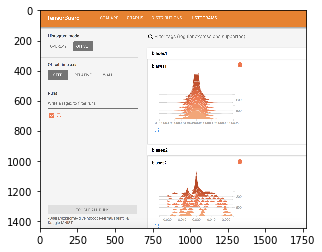

In [3]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open("./tensorboad.png", 'r')
imshow(np.asarray(pil_im))

# スクラッチとの実行時間の比較

上記、出力情報内に、106.669857955。

# Keras
別のjupyter notebookをご参照ください。

# Chainer
別のjupyter notebookをご参照ください。

# Pytorch
別のjupyter notebookをご参照ください。

# スクラッチの修正
dropoutをif文内で実装

# フレームワークの特徴の説明

- TensorFlow: 圧倒的な利用者数でGoogleが実際にプロダクトを生む際に利用しているということで、爆発的に利用者が増えたようです。利用者も多く、スクラッチでの実装に比べ、関数などが用意されているため、より簡単に実装できると言えそうです。面白いのは、どんな計算も、TensorFlowは基本的に全ての計算処理を、計算グラフによって記述する点であると思います（例えば単なる足し算でも）。やはり慣れは必要ですが、数式に落とせるものを深層学習に持っていくのに便利なツールと言えそうです。

- Keras: 層をただただ積み重ねていくだけという、とんでもなく簡単な実装が可能です。実装が簡単な一方、コードだけからは処理の中身を知ることはできません。従って、Kerasを使っていても、ディープラーニングそれ自体の理解には繋がりにくいとも言われています。

- Chainer: 日本産のフレームワークです。利用者は非常に少ないですが、柔軟な計算グラフの構築が可能であることが、最も大きな特徴です。Chainerを皮切りに、この方式に則ったフレームワークも登場してきています（dynetやpytorch)

- Pytorch: Define by Runで、利用者のコミュニティも拡大傾向、研究での利用例も増えてきているとのことで現在最も勢いのあるフレームワークと言えます。Chainerのメリットのほとんどを有するということでChainerに慣れた人も使いやすいです。